This document provides instructions for the installation and running of WRF SCM version 4.3

If you have questions, feel free to contact Christopher Phillips, chris.phillips@uah.edu

Another useful source is the WRF user manual: https://www2.mmm.ucar.edu/wrf/users/docs/user_guide_v4/contents.html

--------------------
# --- Installation ---


Prior to installing WRF, you will need the following modules loaded:

    module load null
    module load netcdf/4.4.0_mpi-pgi16.3_gcc
    module load ncarg/6.3_mpi-pgi16.3_gcc
    module load hdf5/v1.8.17_mpi-pgi16.3_gcc
    module load pgi/16.3
    module load mpich/3.2-pgi16.3

Additionally, you will need the following variables set:

    setenv WRF_EM_CORE 1
    setenv WRF_NMM_CORE 0
    setenv WRFIO_NCD_LARGE_FILE_SUPPORT 1
    setenv ENVCOMPDEFS -DWRF_CHEM
    setenv WRF_CHEM 0
    setenv WRF_KPP 0

    setenv JASPERLIB /common/pkgs/jasper/1.900.1-pgi12.10-EL6_64-201212201430/lib
    setenv JASPERINC /common/pkgs/jasper/1.900.1-pgi12.10-EL6_64-201212201430/include

Note that if you want to use chemistry, set WRF_CHEM to 1 instead of 0. It is recommended to place the module and setenv statements into the .tcshrc.matrix file located in your home directory.

While logged into Matrix, create a new directory for the wrf system and download the latest version
    
    mkdir wrf43
    cd wrf43
    git clone https://github.com/wrf-model/WRF

Then cd into the new WRF directory and run the configuration script

    ./configure

Select option 1 for serial processing using the PGI compilers. When prompted, select no nesting. Note that WRF SCM cannot use multi-processing, this is why option 1 is selected instead of option 3. At this point, the following message should appear

    Testing for NetCDF, C and Fortran compiler

    This installation of NetCDF is 64-bit
        C compiler is 64-bit
        Fortran compiler is 64-bit
        It will build in 64-bit

Now open the newly created configure.wrf file

    vi configure.wrf

And make the following changes

1) SFC = mpifort

2) SCC = h5pcc

3) h5pcc

4) DM_FC = mpifort

5) DM_CC = h5pcc -DMPI2_SUPPORT

6) Add -Kieee to the FCOPTIM variable. Do NOT delete any other flags.

    FCOPTIM = -O3 -Kieee #-fastsse -Mvect=noaltcode -Msmartalloc -Mprefetch=distance:8 -Mfprelaxed # -Minfo=all =Mneginfo=all

Next, run the compilation script and wait. This can take anywhere from 30 minutes to 1.5 hours.

    ./compile em_scm_xy >& compile_scm.log

After compilation, check the log file for successful build of the WRF executables.

    tail compile_scm.log

You should see something similar to the below:

    --->                  Executables successfully built                  <---

    -rwxr-x--- 1 cphillip cphillip 131990352 Oct 19 15:13 main/ideal.exe
    -rwxr-x--- 1 cphillip cphillip 159422160 Oct 19 15:13 main/wrf.exe

If so, congratulations, you have compile the WRF SCM. If not, then check the log file for errors (searching for "severe" is the easiest way) and correct them.

Next, we will discuss running the model.

------------------
# --- Running ---

Running the SCM model is quite simple. Unlike real WRF, which requires pre-processing of analysis files, WRF SCM only requires two ascii input files. One is a sounding, and the other is the soil conditions.

First, cd into the main WRF directory where the configure and compile scripts are located. Then change into the run directory.

    cd run

Check that input_sounding and input_soil exist. If they do not, then copy them from the test directory.

    cp ../test/em_scm_xy/input_sounding input_sounding
    cp ../test/em_scm_xy/input_soil input_soil
    cp ../test/em_scm_xy/README.scm README.scm

The README.scm file describes the ascii input files. Don't worry about generating your own for now though. We'll start with the provided test case and discuss file generation later.

Inside the run directory, there are two executables important to the WRF SCM, ideal.exe and wrf.exe. ideal.exe generates the binary input file, wrfinput_d01, that WRF requires as input. wrf.exe is the model itself and generates an output file. To run the model:

    ./ideal.exe
    ./wrf.exe

And that's it! These commands should properly be submitted to matrix with a slurm script (https://it.nsstc.uah.edu/itwiki/Slurm.queue.html) and submitted using the command:

    sbatch name_of_slurm_script

Next, we'll discuss input file generation and the all important namelist.

---------------
# The namelist

For a full description of the namelist variables, see chapter 5 of the WRF user guide. There are far, far too many to cover here. Instead, I will describe only those most important to the SCM. Do note that the namelist should be set prior to running ideal.exe.

--- time_control

The start variables are straight forward; they control what time the model starts. Note that model time is in UTC. The end variables are the last time of the model run, and the run variables are how long the model runs. I recommend deleting the end variables, and just using the run variables or vice-versa.

history_interval - This is the model time interval between outputted data points. If you want data every 15 minutes, then set it to 15. If you want data every hour, use 60.

frames_per_outfile - This is how many output tiems you want in each output file. Set it to a very large number so that all model times will be in a single file. With real WRF you can't do this because of file size constraints, but SCM runs are tiny. One file is much easier to work with in this case.

auxinput3_interval_h - How often forcing conditions such as advection are applied to the model. This tutorial does not cover generation of a forcing file, so set to -1 for now.

--- domains

time_step - The model time step in seconds. Just like grid spacing that determines the model resoltuion, there is also time spacing. As a rule of thumb, use dx/1000*6. So if dx = 10000, time_step should be 60. Note that time_step should divide evenly into 60 seconds. This keeps your output times lined up with your time_steps.

max_dom - It's 1. This is a SCM.

e_we, e_sn - These are 3. Yes, it's a *single* column model, but the WRF still uses a 3x3 grid even here. Don't worry though, each grid point is identical, so you can just pull whichever one from the output.

e_vert - The number of vertical levels.

dx, dy - The model grid spacing in meters. It seems strange that this matters for an SCM, since you functionally only have 1 grid point, but it does impact things like intergration stability during runtime. If you don't want explicit convection, set it to something more than 4000. If you do want explicit, convection, set it to something less than 4000.

--- scm

scm_force - Whether to read a forcing file. Leave it at 0 for now. 1 would read a file.

scm_lu_index - What's the surface cover? LANDUSE.TBL in the USGS section has the list.

scm_isltyp - What's the soil type? See SOILPARM.TBL for options.

scm_vegfra - Vegetation fraction in percent (0-100)

scm_lat, scm_lon - The location of the model grid. This is important to get radiation and coriolis right.

----------------------
# --- Input File Generation ---

There are two input files for the SCM that you need to run ideal.exe in addition to the namelist, input_soil and input_sounding.

input_soil looks like so:

    0.0000     293.0000     283.0000
    0.0500     290.0000     0.2500
    0.2500     286.0000     0.2500
    0.7000     284.0000     0.2500
    1.5000     283.0000     0.2500

The left column is soil depth. The first line is 0.0 (the surface), the surface temperature, and the deep soil temperature. Each row after that is the soil temperature and the volumetric water content. The land surface temperature can be found from sources like model analysis or satellite products. Soil temperature and moisture is much more difficult to find unless you have a station nearby. These variables are often adjusted by trial-and-error.

input_sounding is described in the README and looks like this:

    508.000 1.806 1.492 298.595 0.016 95223.000
    519.639 1.877 1.589 298.305 0.016
    528.276 2.201 1.984 298.205 0.016
    537.298 2.429 2.222 298.232 0.016
    545.812 2.683 2.513 298.225 0.016
    554.727 2.856 2.709 298.249 0.016
    563.391 3.085 2.967 298.335 0.016
    572.306 3.301 3.202 298.590 0.016
    581.532 3.549 3.452 298.890 0.016
    590.147 3.749 3.631 299.143 0.016
    .
    .
    .

The left column is height above sea level (m) followed by u wind (m/s), v wind (m/s), potential temperature (K), and water vapor mixing ratio (kg/kg). The first line is the surface height (m), 10m u wind (m/s), 10m v wind (m/s), 2m temperature (K), 2m water vapor mixing ratio (kg/kg), and the surface pressure (Pa). The University of Wyoming archives is a good source of soundings, and there is code available on github for writing them to the appropriate format. A demo is included in this guide.

---------------------
# --- Generating input_sounding files ---

The pysonde package available on github is a utility for reading and manipulating a wide array of sounding data formats that are common to the atmospheric sciences. The code may be installed from github via:

    git clone https://github.com/sodoesaburningbus/pysonde
    cd pysonde
    python setup.py install

or

    pip install git+https://github.com/sodoesaburningbus/pysonde

Once installed, donwloading a sounding from the University of Wyoming archive and writing to the WRF SCM input format is easy. See the following example.

In [ ]:
### Install pysonde
!git clone https://github.com/sodoesaburningbus/pysonde
%cd pysonde
!python setup.py install
%cd ..

Cloning into 'pysonde'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 131 (delta 77), reused 68 (delta 31), pack-reused 0
Receiving objects: 100% (131/131), 165.69 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (77/77), done.
/content/pysonde/pysonde
running install
running bdist_egg
running egg_info
creating PySonde.egg-info
writing PySonde.egg-info/PKG-INFO
writing dependency_links to PySonde.egg-info/dependency_links.txt
writing requirements to PySonde.egg-info/requires.txt
writing top-level names to PySonde.egg-info/top_level.txt
writing manifest file 'PySonde.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'PySonde.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/EGG-INFO
copyin

input_sounding.example


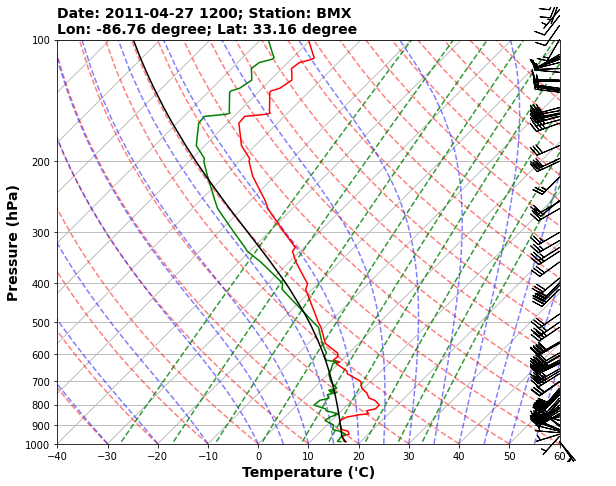

In [ ]:
# Load pysonde
from pysonde.pysonde import PySonde
from datetime import datetime

# Choose a date in UTC (YYYY-MM-DD HH)
date = "2011-04-27 12"

# Choose a station
station = "BMX"

# Load the sounding, plot it, and print to input_sounding
sonde = PySonde("BMX", "web", date=datetime.strptime(date, "%Y-%m-%d %H"))

fig, ax = sonde.basic_skewt()
fig.show()

sonde.write_wrfscm("input_sounding.example")

%ls input_sounding.*